In [1]:
import numpy as np
import numpy.linalg as la
from cosmoTransitions import generic_potential as gp
from matplotlib import pyplot as plt

In [32]:
mZEW = 91.1876
GF = 1.1663787e-05
v = (2**0.5 * GF)**(-0.5)/np.sqrt(2)
v2 = v**2
mhpole = 125.13
g1 = 0.357394
g2 = 0.651016
g3 = 1.21978
yt = 0.977773

In [18]:
v

174.10358473791823

In [36]:
class model_ALP(gp.generic_potential):
    """Effective potential of the model, and some defined functions for computation."""

    def init(self, lh, A, muHsq, muSsq, f, beta):
        self.Ndim = 2
        self.g1 = g1
        self.g2 = g2
        self.g3 = g3
        self.yt = yt
        self.lh = lh
        self.A = A
        self.muHsq = muHsq
        self.muSsq = muSsq
        self.f = f
        self.beta = beta
        self.Tmax = 100
        self.renormScaleSq = mZ**2

    def V0(self, X):
        """Tree-level potential"""

        # Define field variable quantities
        X = np.asanyarray(X)
        assert X.shape[-1] == 2

        h = X[..., 0]
        S = X[..., 1]

        # tree-level potential
        y_h = -0.5 * self.muHsq * h**2 + 0.25 * self.lh * h**4
        y_S = -self.f**2 * self.muSsq**2 * (np.cos(S / self.f) - 1)
        y_hS = (
            -0.5 * self.A * self.f * (h**2 - 2 * v2) * np.sin(self.beta + S / self.f)
        )
        tot = y_h + y_S + y_hS

        return tot

    def Scalar_Matrix(self, X):
        """Physical scalar mass matrix. Goldstone boson excluded."""

        # Define field variable quantities
        X = np.array(X)
        assert X.shape[-1] == 2
        h = X[..., 0]
        S = X[..., 1]

        # Physical calar Matrix Form (tree-level)
        ScalarMatrix = np.multiply.outer(np.ones((2, 2)), 0)
        ScalarMatrix[0, 0] = (
            -self.A * self.f * np.sin(self.beta + S / self.f)
            + 3 * self.lh * h**2
            - self.muHsq
        )
        ScalarMatrix[1, 1] = 0.5 * (
            self.A * (h**2 - 2 * v2) * np.sin(self.beta + S / self.f)
        ) / self.f + self.muSsq * np.cos(S / self.f)
        ScalarMatrix[0, 1] = -self.A * h * np.cos(self.beta + S / self.f)
        ScalarMatrix[1, 0] = -self.A * h * np.cos(self.beta + S / self.f)

        return ScalarMatrix

    def boson_massSq(self, X, T):
        """
        Method of CosmoTransition. Returns bosons mass square, dof and constants. The scalar masses are the eigenvalues of the full physical scalar matrix, plus the Nambu-Goldstone bosons.
        """

        X = np.array(X)
        T = np.asanyarray(T, dtype=float)
        T2 = T * T
        assert X.shape[-1] == 2
        h = X[..., 0]
        S = X[..., 1]

        ScalarMatrix = self.Scalar_Matrix(X)
        ScalarMatrix[0, 0] += (
            3 * self.g2**2 / 16 + self.g1**2 / 16 + 0.5 * self.lh + 0.25 * self.yt
        ) * T2

        ScalarMatrix = np.rollaxis(ScalarMatrix, 0, len(ScalarMatrix.shape))
        mSsq = la.eigvalsh(ScalarMatrix)[0]
        mhsq = la.eigvalsh(ScalarMatrix)[1]

        mgs = (
            self.lh * h**2
            - self.muHsq
            - self.A * self.f * np.sin(S / self.f + self.beta)
        )

        mW = 0.25 * self.g2**2 * h**2
        mWL = mW + 11 * self.g2**2 * T2 / 11
        mZ = 0.25 * (self.g2**2 + self.g1**2) * h**2

        AZsq = np.sqrt(
            (self.g2**2 + self.g1**2) ** 2 * (3 * h**2 + 22 * T2) ** 2
            - 176 * self.g2**2 * self.g1**2 * T2 * (3 * h**2 + 11 * T2)
        )

        mZL = ((self.g2**2 + self.g1**2) * (3 * h**2 + 22 * T2) + AZsq) / 24
        mAL = ((self.g2**2 + self.g1**2) * (3 * h**2 + 22 * T2) - AZsq) / 24

        M = np.array([mSsq, mhsq, mgs, mW, mWL, mZ, mZL, mAL])
        M = np.rollaxis(M, 0, len(M.shape))

        dof = np.array([1, 1, 3, 4, 2, 2, 1, 1])
        c = np.array([1.5, 1.5, 1.5, 0.5, 1.5, 0.5, 1.5, 1.5])

        return M.real + 1e-16, dof, c

    def fermion_massSq(self, X):
        """
        Method of CosmoTransition. Fermion mass square. Only top quark is included.
        """

        X = np.array(X)
        h = X[..., 0]

        mt = 0.5 * self.yt * h**2
        Mf = np.array([mt])
        Mf = np.rollaxis(Mf, 0, len(Mf.shape))

        doff = np.array([12.0])

        return Mf, doff

    def V1(self, bosons, fermions, scale=mZEW):
        """
        Method of CosmoTransition. Overwritten.

        The 1-loop CW correction at the zero-temperature in the
        MS-bar renormalization scheme.
        """

        scale2 = scale**2
        m2, n, c = bosons
        y = np.sum(n * m2 * m2 * (np.log(m2 / scale2 + 1e-100 + 0j) - c), axis=-1)
        m2, n = fermions
        c = 1.5
        y -= np.sum(n * m2 * m2 * (np.log(m2 / scale2 + 1e-100 + 0j) - c), axis=-1)
        return y.real / (64 * np.pi * np.pi)

    def V0T(self, X):
        X = np.asanyarray(X, dtype=float)

        bosons = self.boson_massSq(X, 0)
        fermions = self.fermion_massSq(X)

        y = self.V0(X)
        y += self.V1(bosons, fermions)

        return y


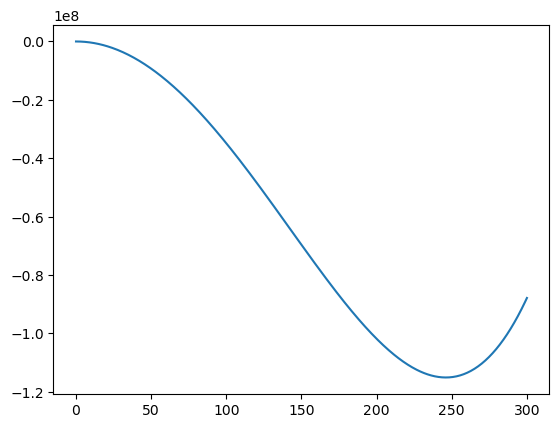

In [50]:
model = model_ALP(0.125559, 11.1902, -338194, 21.8353**2, 1e5, np.pi/10)
h_list = np.linspace(0,300,500)
y_list_tree = [model.V0([i,0])-model.V0([1e-16,0]) for i in h_list]
plt.plot(h_list, y_list_tree)
# test tree-level

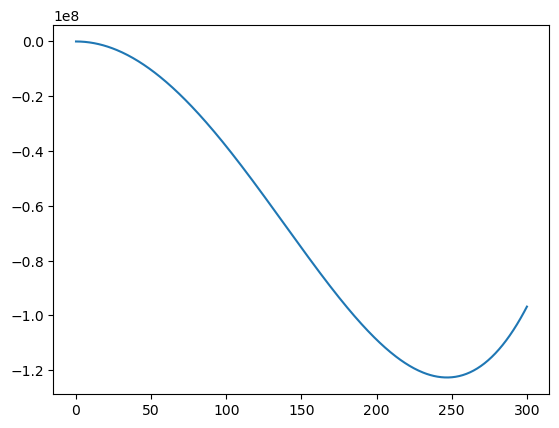

In [51]:
model = model_ALP(0.14707, 11.264, -339459, 480.134, 1e5, np.pi/10)
h_list = np.linspace(0,300,500)
y_list = [model.V0T([i,0])-model.V0T([1e-16,0]) for i in h_list]
plt.plot(h_list, y_list)
# test 1-loop level

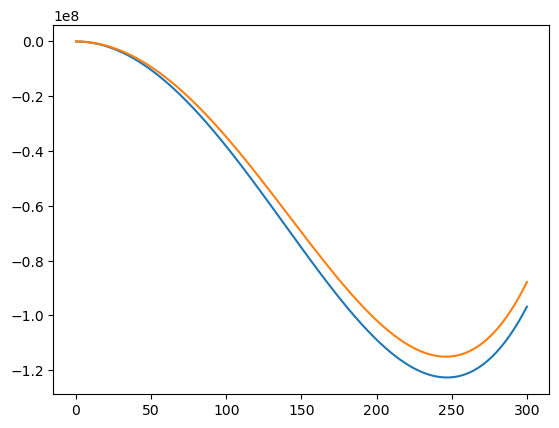

In [52]:
plt.plot(h_list, y_list)
plt.plot(h_list, y_list_tree)